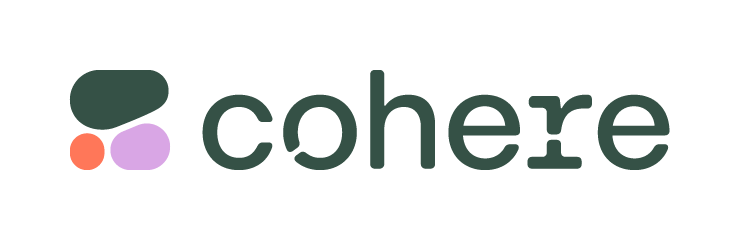

# Notebook Overview

## Motivation 

Tabular data reasoning continues to be an exciting application of Agents, particularly in the financial domain, where multiple reasoning steps may be needed to identify the right answer. For example, a financial analyst working with financial statements may be interested in computing various financial ratios with natural language queries.

Some examples may include:
- ROE (Return on Equity) = Net Income / Shareholder's Equity
- Net Profit Margin = Net Income / Revenue
- Asset Turnover = Revenue / Average Total Assets
- Financial Leverage = Average Total Assets / Shareholder's Equity

Having an Agent which is able to correctly compute these and other ratios would be a great help for any analyst in the field of Finance.

## Objective

In this notebook we explore how to setup a [Cohere Agent](https://docs.cohere.com/docs/multi-step-tool-use) to answer questions over tables in Apple's SEC10K 2020 form. [financial_csv_publication.ipynb](#TODO) already showed how to use langchain to ask questions about your data. This notebook will demonstrate how you can build the same agent using Cohere's native API with langchain python tool. We will also explore how to make your agent more resilient to errors. 

## Table of Contents

- [Setup](#sec_step0)
- [Introduction](#sec_step1)
- [QnA over Single Table](#sec_step2)
    - [Agent with Python Tool](#sec_step2_sub1)
    - [Agent with Python Tool that takes tables as input](#sec_step2_sub2)
- [QnA over Multiple Tables](#sec_step3)

# Setup

In [47]:
import json
import pandas as pd
import os
from typing import List, Any
from langchain_core.pydantic_v1 import BaseModel, Field
import langchain
# from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain.agents import Tool
import langchain_experimental
from langchain_experimental.utilities import PythonREPL
import langchain_core
import cohere

import os
import pandas as pd
import requests
import json


In [ ]:
####################################################################################################
#
# Uncomment if you need to install the following packages
#
####################################################################################################

#!pip install --quiet langchain langchain_experimental cohere --upgrade

In [48]:
# versions
print('cohere version:', cohere.__version__)
print('langchain version:', langchain.__version__)
print('langchain_core version:', langchain_core.__version__)
print('langchain_experimental version:', langchain_experimental.__version__)

cohere version: 5.5.0
langchain version: 0.2.0
langchain_core version: 0.2.0
langchain_experimental version: 0.0.59


### API Key 

In [49]:
COHERE_API_KEY = os.environ["COHERE_API_KEY"]
CHAT_URL= "https://api.cohere.ai/v1/chat"
MODEL = 'command-r-plus'

### Data Loading 

In [50]:
income_statement = pd.read_csv('income_statement.csv')
balance_sheet = pd.read_csv('balance_sheet.csv')

In [51]:
income_statement.head(2)

,Unnamed: 0,index,RevenueFromContractWithCustomerExcludingAssessedTax,CostOfGoodsAndServicesSold,GrossProfit,ResearchAndDevelopmentExpense,SellingGeneralAndAdministrativeExpense,OperatingExpenses,OperatingIncomeLoss,NonoperatingIncomeExpense,IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,IncomeTaxExpenseBenefit,NetIncomeLoss,EarningsPerShareBasic,EarningsPerShareDiluted,WeightedAverageNumberOfSharesOutstandingBasic,WeightedAverageNumberOfDilutedSharesOutstanding
0,0,2017-10-01-2018-09-29,265595000000,1.637560e+11,101839000000,1.423600e+10,1.670500e+10,3.094100e+10,7.089800e+10,2.005000e+09,7.290300e+10,1.337200e+10,59531000000,3.00,2.98,1.982151e+10,2.000044e+10
1,1,2018-09-30-2018-12-29,84310000000,NaN,32031000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19965000000,1.05,1.05,NaN,NaN


In [52]:
balance_sheet.head(2)

,Unnamed: 0,index,CashAndCashEquivalentsAtCarryingValue,MarketableSecuritiesCurrent,AccountsReceivableNetCurrent,InventoryNet,NontradeReceivablesCurrent,OtherAssetsCurrent,AssetsCurrent,MarketableSecuritiesNoncurrent,...,LongTermDebtNoncurrent,OtherLiabilitiesNoncurrent,LiabilitiesNoncurrent,Liabilities,CommitmentsAndContingencies,CommonStocksIncludingAdditionalPaidInCapital,RetainedEarningsAccumulatedDeficit,AccumulatedOtherComprehensiveIncomeLossNetOfTax,StockholdersEquity,LiabilitiesAndStockholdersEquity
0,0,2017-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134047000000,NaN
1,1,2018-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107147000000,NaN


### Define Python Tool 

In [ ]:

python_repl = PythonREPL()
python_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
python_tool.name = "python_interpreter"

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
python_tool.args_schema = ToolInput

def run_python_code(code: str) -> dict:
    """
    Function to run given python code
    """
    input_code = ToolInput(code=code)
    return {'python_answer': python_tool.func(input_code.code)}

functions_map = {
    "run_python_code": run_python_code,
}

tools = [
    {
        "name": "run_python_code",
        "description": "given a python code, runs it",
        "parameter_definitions": {
            "code": {
                "description": "executable python code",
                "type": "str",
                "required": True
            }
        }
    },]




## Create Agent Wrapper 

As [Vanilla_Multi_Step_Tool_Use.ipynb](https://github.com/cohere-ai/notebooks/blob/fbf6c8dad47d7557314e9248a267175c7a6908d8/notebooks/Vanilla_Multi_Step_Tool_Use.ipynb) shows, you have a lot of flexiblity on how you can customize and interact with the cohere agent. Here I am creating a wrapper so that it automatically determines when to stop calling the tools and output final answer. 

In [ ]:
def cohere_agent(message: str, preamble: str, tools: List[dict], multi_step=True, verbose: bool = False) -> str:
    """
    Function to handle multi-step tool use api.

    Args:
        message (str): The message to send to the Cohere AI model.
        preamble (str): The preamble or context for the conversation.
        tools (list of dict): List of tools to use in the conversation.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        str: The final response from the call.
    """

    tool_results = []
    responses = []

    for _ in range(15): # max 15 steps

        if verbose:
            print(f'\nRunning {len(responses)}th step')

        response = requests.post(
            CHAT_URL,
            headers={'Authorization': f'Bearer {COHERE_API_KEY}', 'content-type': 'application/json'},
            data=json.dumps({
                "message": message,
                "tools": tools,
                "preamble": preamble,
                "chat_history": responses[-1]['chat_history'] if responses else None, # chat history from the latest response
                "tool_results": tool_results[-1] if tool_results else None, # tool results from the latest response
                "model": MODEL,
                # "enable_multi_step": multi_step,
        }))
        response = json.loads(response.content)
        responses.append(response)

        if verbose:
            print(response['text'])

        # if the model has directly answered, exit and return the text
        if 'tool_calls' not in response['chat_history'][-1]:
            return response['text']
        else:
            # run tools
            tool_results_tmp = []
            for tool_call in responses[-1]['chat_history'][-1]['tool_calls']:
                output = functions_map[tool_call['name']](**tool_call['parameters'])
                outputs = [output]
                if verbose:
                    print(f"= running tool {tool_call['name']}, with parameters: {tool_call['parameters']}")
                    print(f"== tool results: {outputs}")
                tool_results_tmp.append({
                    "call": tool_call,
                    "outputs": outputs
                })
            tool_results.append(tool_results_tmp)


# QnA over Single Table 

In [22]:
question_dict ={
    'q1': ['what is the highest value of cost of goods and service?',169559000000],
    'q2': ['what is the largest gross profit margin?',0.3836194330595236],
    'q3': ['what is the minimum ratio of operating income loss divided by non operating income expense',35.360599]
}

In [21]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
Here is a preview of the dataframe:
{head_df}
""".format(head_df=income_statement.head(3).to_markdown())

question1 = "what is the highest value of cost of goods and service?"

output = cohere_agent(question1, preamble, tools, verbose=True)



Running 0th step
I will use Python to find the highest value of 'CostOfGoodsAndServicesSold' in the dataframe.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv("income_statement.csv")\n\n# Find the highest value of \'CostOfGoodsAndServicesSold\'\nhighest_cost = df["CostOfGoodsAndServicesSold"].max()\n\nprint(f"The highest value of \'CostOfGoodsAndServicesSold\' is {highest_cost}")'}
== tool results: [{'python_answer': "The highest value of 'CostOfGoodsAndServicesSold' is 169559000000.0\n"}]

Running 1th step
The highest value of 'CostOfGoodsAndServicesSold' is 169559000000.0.


In [23]:
for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    question = val[0]
    answer = val[1]
    output = cohere_agent(question, preamble, tools, verbose=True)
    print(f'GT Answer:{val[1]}')
    print('-'*50)

question:q1

Running 0th step
I will use Python to find the highest value of 'CostOfGoodsAndServicesSold' in the dataframe.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv("income_statement.csv")\n\n# Find the highest value of \'CostOfGoodsAndServicesSold\'\nhighest_cost = df["CostOfGoodsAndServicesSold"].max()\nprint(f"The highest value of \'CostOfGoodsAndServicesSold\' is {highest_cost}")'}
== tool results: [{'python_answer': "The highest value of 'CostOfGoodsAndServicesSold' is 169559000000.0\n"}]

Running 1th step
The highest value of 'CostOfGoodsAndServicesSold' is 169559000000.0.
GT Answer:169559000000
--------------------------------------------------
question:q2

Running 0th step
I will write and execute python code to find the largest gross profit margin.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv("income_statement.csv")\n\n# Calculate gross profit margin\ndf["GrossProfit

In [20]:
print(output)

The highest value of 'CostOfGoodsAndServicesSold' is 169559000000.0.


<a id="sec_step3"></a>

# QnA over Multiple Tables 

We now make the task for the Agent more complicated, by asking it questions whose answer can be computed only by retrieving relevant information from multiple tables.

In [25]:
question_dict ={
    'q1': ['what is the ratio of the largest stockholders equity to the smallest revenue'],
}

The answer to this question can be obtained only by accessing both the balance sheet and the income statement, as show below:

In [24]:
# get the largest stockholders equity
x = balance_sheet['StockholdersEquity'].astype(float).max()
print(f"The largest stockholders equity value is: {x}")

# get the smallest revenue
y = income_statement['RevenueFromContractWithCustomerExcludingAssessedTax'].astype(float).min()
print(f"The smallest revenue value is: {y}")

# compute the ratio
ratio = x/y
print(f"Their ratio is: {ratio}")

The largest stockholders equity value is: 134047000000.0
The smallest revenue value is: 53809000000.0
Their ratio is: 2.4911631883142227


In [ ]:
for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    question = val[0]
    answer = val[1]
    output = cohere_agent(question, preamble, tools, verbose=True)
    print(f'GT Answer:{val[1]}')
    print('-'*50)

In [27]:
preamble = """
You are an expert who answers the user's question in complete sentences. You are working with two pandas dataframe in Python. Ensure your output is a string.

Here is a preview of the `income_statement.csv` dataframe:
{table_1}

Here is a preview of the `balance_sheet.csv` dataframe:
{table_2}
""".format(table_1=income_statement.head(3).to_markdown(),table_2=balance_sheet.head(3).to_markdown())


for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    question = val[0]
    output = cohere_agent(question, preamble, tools, verbose=True)

question:q1

Running 0th step
I will use Python to find the largest stockholder's equity and the smallest revenue, then I will calculate the ratio between the two.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\n# Read the data\ndf_income_statement = pd.read_csv("income_statement.csv")\ndf_balance_sheet = pd.read_csv("balance_sheet.csv")\n\n# Find the smallest revenue\nsmallest_revenue = df_income_statement["RevenueFromContractWithCustomerExcludingAssessedTax"].min()\n\n# Find the largest stockholder\'s equity\nlargest_stockholders_equity = df_balance_sheet["StockholdersEquity"].max()\n\n# Calculate the ratio\nratio = largest_stockholders_equity / smallest_revenue\n\nprint(f"The ratio of the largest stockholder\'s equity to the smallest revenue is {ratio:.2f}")'}
== tool results: [{'python_answer': "The ratio of the largest stockholder's equity to the smallest revenue is 2.49\n"}]

Running 1th step
The ratio of the largest stockholder's equity to the s

# Error Resilience

In the previous examples, the model successfully answered your questions. However, the model may not always have access to the preview of the data. Let's see what happens when we remove the preview from the preamble.  

In [28]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
"""

question1 = "what is the highest value of cost of goods and service?"

output = cohere_agent(question1, preamble, tools, verbose=True)



Running 0th step
I will write and execute Python code to find the highest value of cost of goods and service.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'income_statement.csv\')\n\n# Find the maximum value of \'Cost of Goods and Services\'\nmax_cost_of_goods_and_services = df[\'Cost of Goods and Services\'].max()\n\nprint(f"The highest value of \'Cost of Goods and Services\' is: {max_cost_of_goods_and_services}")'}
== tool results: [{'python_answer': "KeyError('Cost of Goods and Services')"}]

Running 1th step
Sorry, there seems to be an error with the data. Can you please check the column name and try again?


As you see above the model failed to execute because it assumed certain column names but they turned out to be wrong. One simple fix is to tell the model to continue to solve the problem in the face of error. 

In [39]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
If you run into error, keep trying until you fix it. You may need to view the data to understand the error.
"""

question1 = "what is the highest value of cost of goods and service?"

output = cohere_agent(question1, preamble, tools, verbose=True)



Running 0th step
I will write and execute Python code to find the highest value of 'cost of goods and service' from the given dataframe.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'income_statement.csv\')\n\n# Find the highest value of \'Cost of Goods and Services\'\nhighest_cost = df[\'Cost of Goods and Services\'].max()\n\nprint(f"The highest value of \'Cost of Goods and Services\' is: {highest_cost}")'}
== tool results: [{'python_answer': "KeyError('Cost of Goods and Services')"}]

Running 1th step
I encountered an error. I will now view the dataframe to understand the error.
= running tool run_python_code, with parameters: {'code': "import pandas as pd\n\ndf = pd.read_csv('income_statement.csv')\n\nprint(df)"}
== tool results: [{'python_answer': '    Unnamed: 0                  index  \\\n0            0  2017-10-01-2018-09-29   \n1            1  2018-09-30-2018-12-29   \n2            2  2018-09-30-2019-09-28   \n3           

### Add Viewing Tool 

What if we add viewing data as a tool so that model can explicitly use it instead of indirectly figuring it out? 

In [41]:
def view_csv_data(path: str) -> dict:
    """
    Function to view the head, tail and shape of a given csv file.
    """
    df = pd.read_csv(path)

    return {
        "head": df.head().to_string(),
        "tail": df.tail().to_string(),
        "shape": str(df.shape),
    }

functions_map = {
    "run_python_code": run_python_code,
    "view_csv_data": view_csv_data
}

tools = [
    {
        "name": "run_python_code",
        "description": "given a python code, runs it",
        "parameter_definitions": {
            "code": {
                "description": "executable python code",
                "type": "str",
                "required": True
            }
        }
    },
    {
        "name": "view_csv_data",
        "description": "give path to csv data and get head, tail and shape of the data",
        "parameter_definitions": {
            "path": {
                "description": "path to csv",
                "type": "str",
                "required": True
            }
        }
    },
]

In [45]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
Always view the data first to write flawless code.
"""

question1 = "what is the highest value of cost of goods and service?"

output = cohere_agent(question1, preamble, tools, verbose=True)


Running 0th step
I will first view the data to understand the column names and then write and execute Python code to find the highest value of the cost of goods and services.
= running tool view_csv_data, with parameters: {'path': 'income_statement.csv'}
== tool results: [{'head': '   Unnamed: 0                  index  RevenueFromContractWithCustomerExcludingAssessedTax  CostOfGoodsAndServicesSold   GrossProfit  ResearchAndDevelopmentExpense  SellingGeneralAndAdministrativeExpense  OperatingExpenses  OperatingIncomeLoss  NonoperatingIncomeExpense  IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest  IncomeTaxExpenseBenefit  NetIncomeLoss  EarningsPerShareBasic  EarningsPerShareDiluted  WeightedAverageNumberOfSharesOutstandingBasic  WeightedAverageNumberOfDilutedSharesOutstanding\n0           0  2017-10-01-2018-09-29                                         265595000000                1.637560e+11  101839000000                   1.423600e+10      

By being prescriptive, we were able to cut down a step and get to the answer faster. 